In [64]:
import vectorbt as vbt
import pandas_ta as ta

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [22]:
data = pd.read_csv('data/btc.csv', index_col=0, parse_dates=True)
# just keep the 'Close' column
data = data['Close'].to_frame()

In [ ]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1m" # minutely data

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.0005 # 0.05%
# vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
# vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

In [45]:
# Create an indicator of the SMA of the close price

sma_period = 100
data.ta.sma(close='Close', length=sma_period, append=True)
data.dropna(inplace=True)
data

,Close,SMA_5,signal,forecast_5,future,SMA_100,forecast_1,SMA_1000
Open time,,,,,,,,
2022-01-02 04:23:00+00:00,47313.36,47309.734,-0.000400,-0.000146,47313.37,47361.8845,2.113568e-07,47332.31145
2022-01-02 04:24:00+00:00,47313.37,47311.622,-0.000408,-0.000159,47313.56,47361.3141,4.015778e-06,47332.67846
2022-01-02 04:25:00+00:00,47313.56,47310.734,-0.000412,-0.000287,47318.43,47360.6130,1.029303e-04,47333.04681
2022-01-02 04:26:00+00:00,47318.43,47313.074,-0.000317,-0.000477,47290.01,47359.9566,-6.006116e-04,47333.41193
2022-01-02 04:27:00+00:00,47290.01,47309.746,-0.000924,0.000592,47306.44,47359.2266,3.474307e-04,47333.74748
...,...,...,...,...,...,...,...,...
2023-02-10 01:29:00+00:00,21818.74,21829.976,-0.024514,0.001236,21824.53,21832.1047,2.653682e-04,22367.03698
2023-02-10 01:30:00+00:00,21824.53,21828.328,-0.024215,0.000987,21820.46,21832.2053,-1.864874e-04,22366.13647
2023-02-10 01:31:00+00:00,21820.46,21825.452,-0.024358,0.001496,21820.85,21832.3444,1.787313e-05,22365.23623


In [66]:
forecast = 5
data['signal'] = (data['Close']/data[f'SMA_{sma_period}'])-1
data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
data['future'] = data['Close'].shift(-forecast)
data.dropna(inplace=True)
data.head(10)

,Close,SMA_5,signal,forecast_5,future,SMA_100,forecast_1,SMA_1000,forecast_10
Open time,,,,,,,,,
2022-01-02 04:54:00+00:00,46809.24,46863.164,-0.010398,0.002159,46910.30,47301.0781,0.001169,47341.71389,0.002459
2022-01-02 04:55:00+00:00,46863.94,46852.320,-0.009146,0.000274,46876.77,47296.5209,-0.000060,47341.62060,0.002131
2022-01-02 04:56:00+00:00,46861.11,46849.038,-0.009113,0.001491,46930.96,47292.1028,0.000971,47341.50491,0.002294
2022-01-02 04:57:00+00:00,46906.60,46847.942,-0.008074,0.000612,46935.31,47288.4020,0.001114,47341.44967,0.001821
2022-01-02 04:58:00+00:00,46958.84,46879.946,-0.006902,-0.000174,46950.66,47285.2232,-0.001034,47341.46799,0.000436
2022-01-02 04:59:00+00:00,46910.30,46900.158,-0.007852,0.000300,46924.36,47281.5311,-0.000715,47341.43133,0.001120
2022-01-02 05:00:00+00:00,46876.77,46902.724,-0.008469,0.001857,46963.81,47277.1582,0.001156,47341.35789,0.001670
2022-01-02 05:01:00+00:00,46930.96,46916.694,-0.007243,0.000802,46968.62,47273.3759,0.000093,47341.31602,0.000086
2022-01-02 05:02:00+00:00,46935.31,46922.436,-0.007065,0.001208,46992.00,47269.2776,0.000327,47341.28787,0.000169


In [56]:
data['signal'].describe()

count    581539.000000
mean         -0.000060
std           0.004933
min          -0.083281
25%          -0.001731
50%           0.000021
75%           0.001721
max           0.072678
Name: signal, dtype: float64

In [57]:
# Check the correlation between signal and forecast_5
correlation = data['signal'].corr(data[f'forecast_{forecast}'])
print(f'The correlation between signal and the future return is: {correlation}')

# Check the min, max and mean of the profit from buying and holding for the forecast period
data[f'forecast_{forecast}'].describe()

The correlation between signal and the future return is: -0.007755885727663622


count    581539.000000
mean         -0.000009
std           0.002758
min          -0.060766
25%          -0.001013
50%           0.000007
75%           0.001016
max           0.071245
Name: forecast_10, dtype: float64

In [58]:
df = data.copy()

In [80]:
# Create the features (X) and target (y) data using numpy
X = df['signal'].iloc[:-forecast].values.reshape(-1, 1) # signal
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())

RandomForestRegressor(n_jobs=-1, random_state=42)

In [82]:
# Calculate the prediction accuracy
threshold = 0.0005

y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df['signal'][-len(y_val):] # signal
X_val = X_val.values.reshape(-1, 1) # reshape to 2D
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
y_pred = model.predict(X_val)
# remove NaNs
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

mse = mean_squared_error(y_pred, y_val)
rmse = np.sqrt(mse)
correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
direction_accuracy = direction_correct.mean() * 100
accuracy = np.mean(correct_predictions) * 100

print(f"For a threshold of: {threshold}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse:.4f}")
# print accuracy within 4 decimal places
print(f"Accuracy: {accuracy:.4f}%")
print(f"Direction Accuracy: {direction_accuracy:.4f}%")


For a threshold of: 0.0005
MSE: 2.5557579175576114e-06
RMSE: 0.0016
Accuracy: 39.7813%
Direction Accuracy: 58.5851%


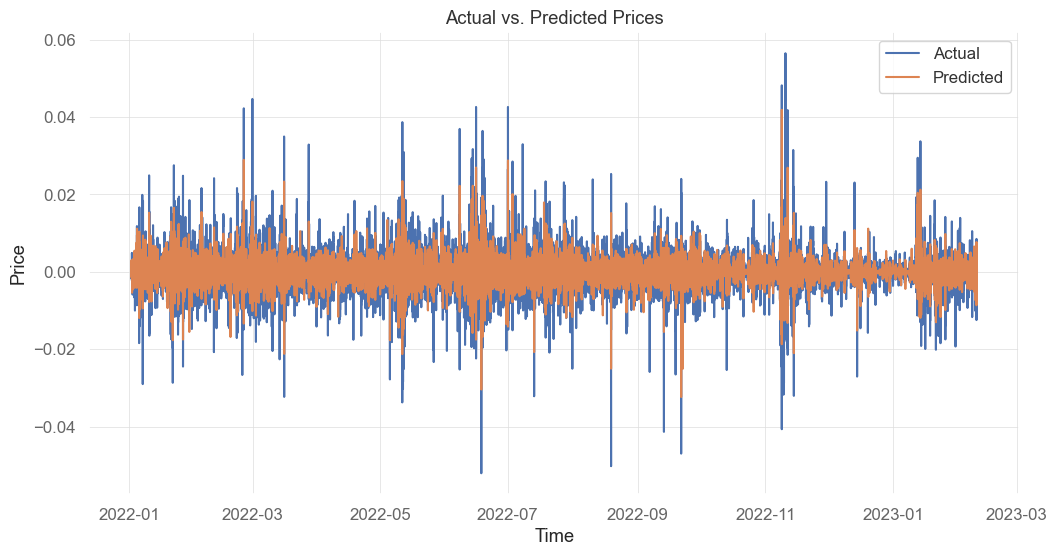

In [84]:
import matplotlib.pyplot as plt

# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_val):], y_val, label='Actual')
plt.plot(df.index[-len(y_val):], y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

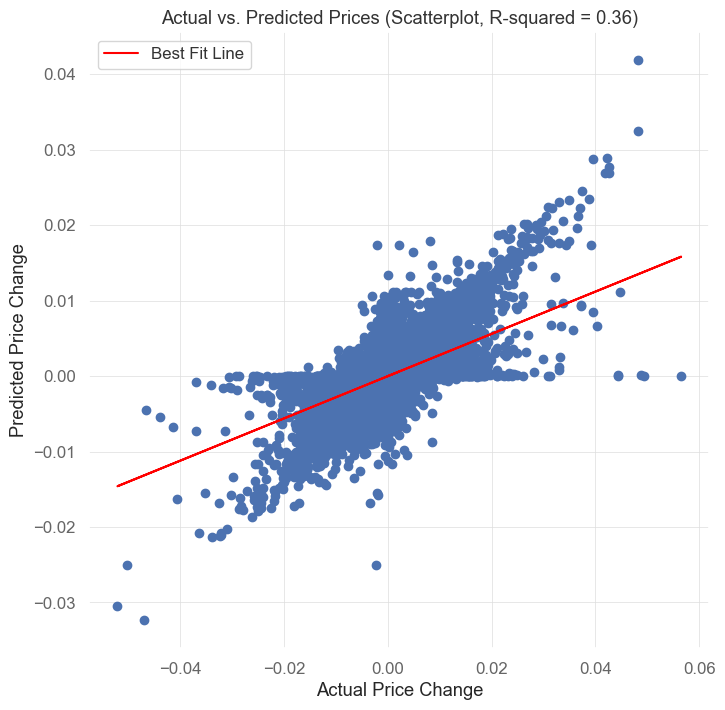

In [87]:


# Calculate R-squared value
r2 = np.corrcoef(y_val.ravel(), y_pred.ravel())[0][1] ** 2

# Fit a line of best fit to the data
coeffs = np.polyfit(y_val.ravel(), y_pred.ravel(), 1)
line = coeffs[0] * y_val.ravel() + coeffs[1]

# Plot actual vs predicted prices as scatterplot
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred)
plt.xlabel('Actual Price Change')
plt.ylabel('Predicted Price Change')
plt.title(f'Actual vs. Predicted Prices (Scatterplot, R-squared = {r2:.2f})')

# Add best fit line
plt.plot(y_val.ravel(), line, color='red', label='Best Fit Line')
plt.legend()

plt.show()


In [93]:
# Define the range of SMA periods to test
sma_periods = np.arange(1000, 5000, 1000)

# Create an empty 2D array to store the R-squared values
rsquareds = np.zeros((len(sma_periods), len(sma_periods)))

# Loop over all pairs of SMA periods
for i, sma_period_1 in enumerate(sma_periods):
    for j, sma_period_2 in enumerate(sma_periods):
        if j >= i: # use symmetry
            # Compute the features and target data
            data.ta.sma(close='Close', length=sma_period_1, append=True)
            data.ta.sma(close='Close', length=sma_period_2, append=True)
            data.dropna(inplace=True)

            forecast = 5
            data['signal'] = (data['Close']/data[f'SMA_{sma_period_1}'])-1
            data['volume_pct_change'] = data['Volume'].pct_change()
            data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
            data['future'] = data['Close'].shift(-forecast)
            data.dropna(inplace=True)

            df = data.copy()

            # Create the features (X) and target (y) data using numpy
            X = df[['signal', 'volume_pct_change']].iloc[:-forecast].values # signal and volume_pct_change
            y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values # future

            # Split the data into training and testing sets and make sure they are the same length
            min_length = min(len(X), len(y))
            X = X[:min_length]
            y = y[:min_length]

            # Create the model and fit it to the data
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            model.fit(X, y.ravel())

            # Calculate the R-squared value and store it in the 2D array
            y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
            X_val = df[['signal', 'volume_pct_change']][-len(y_val):] # signal and volume_pct_change
            y_pred = model.predict(X_val)
            rsquared = np.corrcoef(y_val.ravel(), y_pred.ravel())[0][1] ** 2
            rsquareds[i, j] = rsquared
            rsquareds[j, i] = rsquared

# Create the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(rsquareds, cmap='viridis', origin='lower')
plt.xticks(np.arange(len(sma_periods)), sma_periods)
plt.yticks(np.arange(len(sma_periods)), sma_periods)
plt.xlabel('SMA Period 2')
plt.ylabel('SMA Period 1')
plt.title('R-squared Values for Different SMA Periods')
plt.colorbar()
plt.show()


KeyError: 'Volume'